# Acids and Bases I

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as spo

## Definitions 

The reaction of acids with water has to be recorded as follows: 

$$ AH(aq) + H_2O(l) \rightleftharpoons A^-(aq) + H_3O^+(l) $$

where $AH/A^-$ is an acid-base couple.

# Using a numerical method for Acid/Bases calculations

In [3]:
#https://github.com/rnelsonchem/pHcalc/blob/master/pHcalc/pHcalc.py
#https://pypi.org/project/pHcalc/

class Neutral(object):
    """A nonreactive ion class.
    This object defines things like K+ and Cl-, which contribute to the
    overall charge balance, but do not have any inherent reactivity with
    water.
    
    Parameters
    ----------
    charge : int
        The formal charge of the ion.
    conc : float
        The concentration of this species in solution.
    Attributes
    ----------
    charge : int
        The formal charge of the ion.
    conc : float
        The concentration of this species in solution.
    """
    def __init__(self, charge=None, conc=None):
        if charge == None:
            raise ValueError(
                "The charge for this ion must be defined.")

        self.charge = charge 
        self.conc = conc

    def alpha(self, pH):
        '''Return the fraction of each species at a given pH.
        Parameters
        ----------
        pH : int, float, or Numpy Array
            These are the pH value(s) over which the fraction should be
            returned.
        Returns
        -------
        Numpy NDArray
            Because this is a non-reactive ion class, this function will
            always return a Numpy array containing just 1.0's for all pH
            values.
        '''
        if isinstance(pH, (int, float)):
            length = 1
        else:
            length = len(pH)
        ones = np.ones(length).reshape(-1,1)
        return ones


        
class Acid(object):
    '''An acidic species class.
    This object is used to calculate a number of parameters related to a weak
    acid in an aqueous solution. 
    
    Parameters
    ----------
    Ka : None (default), float, list, Numpy Array
        This defines the Ka values for all acidic protons in this species. It
        can be a single Ka value (float), a list of floats, or a Numpy array
        of floats. Either this value or pKa needs to be defined. The other
        will then be calculated from the given values.
    pKa : None (default), float, list, Numpy Array
        The pKa value(s) for all the acidic protons in this species.  This
        follows the same rules as Ka (See Ka description for more details),
        and either this value or Ka must be defined.
    charge : None (default), int
        This is the charge of the fully protonated form of this acid. This
        must be defined.
    conc : None (default), float
        The formal concentration of this acid in solution. This value must be
        defined.
    Note
    ----
    There is no corresponding Base object. To define a base, you must use a
    combination of an Acid and Neutral object. See the documentation for
    examples.
    '''
    def __init__(self, Ka=None, pKa=None, charge=None, conc=None):
        # Do a couple quick checks to make sure that everything has been
        # defined.
        if Ka == None and pKa == None:
            raise ValueError(
                "You must define either Ka or pKa values.")
        elif charge == None:
            raise ValueError(
                "The maximum charge for this acid must be defined.")

        # Make sure both Ka and pKa are calculated. For lists of values, be
        # sure to sort them to ensure that the most acidic species is defined
        # first.
        elif Ka == None:
            if isinstance(pKa, (int, float)):
                self.pKa = np.array( [pKa,], dtype=float)
            else:
                self.pKa = np.array(pKa, dtype=float)
                self.pKa.sort()
            self.Ka = 10**(-self.pKa) 
        elif pKa == None:
            if isinstance(Ka, (int, float)):
                self.Ka = np.array( [Ka,], dtype=float)
            else:
                self.Ka = np.array(Ka, dtype=float)
                # Ka values must be in reverse sort order
                self.Ka.sort()
                self.Ka = self.Ka[::-1]
            self.pKa = -np.log10(self.Ka)
        # This temporary Ka array will be used to calculate alpha values. It
        # starts with an underscore so that it won't be confusing for others.
        self._Ka_temp = np.append(1., self.Ka)
        
        # Make a list of charges for each species defined by the Ka values.
        self.charge = np.arange(charge, charge - len(self.Ka) - 1, -1)
        # Make sure the concentrations are accessible to the object instance.
        self.conc = conc 

    def alpha(self, pH):
        '''Return the fraction of each species at a given pH.
        Parameters
        ----------
        pH : int, float, or Numpy Array
            These are the pH value(s) over which the fraction should be
            returned.
        Returns
        -------
        Numpy NDArray
            These are the fractional concentrations at any given pH. They are
            sorted from most acidic species to least acidic species. If a
            NDArray of pH values is provided, then a 2D array will be
            returned. In this case, each row represents the speciation for
            each given pH.
        '''
        # If the given pH is not a list/array, be sure to convert it to one
        # for future calcs.
        if isinstance(pH, (int, float)):
            pH = [pH,]
        pH = np.array(pH, dtype=float)

        # Calculate the concentration of H3O+. If multiple pH values are
        # given, then it is best to construct a two dimensional array of
        # concentrations.
        h3o = 10.**(-pH)
        if len(h3o) > 1:
            h3o = np.repeat( h3o.reshape(-1, 1), len(self._Ka_temp), axis=1)

        # These are the powers that the H3O+ concentrations will be raised.
        power = np.arange(len(self._Ka_temp))
        # Calculate the H3O+ concentrations raised to the powers calculated
        # above (in reverse order).
        h3o_pow = h3o**( power[::-1] )
        # Calculate a cumulative product of the Ka values. The first value
        # must be 1.0, which is why _Ka_temp is used instead of Ka.
        Ka_prod = np.cumproduct(self._Ka_temp)
        # Multiply the H3O**power values times the cumulative Ka product.
        h3o_Ka = h3o_pow*Ka_prod

        # Return the alpha values. The return signature will differ is the
        # shape of the H3O array was 2-dimensional. 
        if len(h3o.shape) > 1:
            den = h3o_Ka.sum(axis=1)
            return h3o_Ka/den.reshape(-1,1)
        else:
            den = h3o_Ka.sum()
            return h3o_Ka/den


class System(object):
    '''An object used to define an a system of acid and neutral species.
    This object accepts an arbitrary number of acid and neutral species
    objects and uses these to calculate the pH of the system. Be sure to
    include all of the species that completely define the contents of a
    particular solution.
    Parameters
    ----------
    *species 
        These are any number of Acid and Neutral objects that you'd like to
        use to define your system.
    Attibutes
    ---------
    species : list
        This is a list containing all of the species that you input.
    pHsolution 
        This is the full minimization output, which is defined by the function
        scipy.optimize.minimize. This is only available after running the
        pHsolve method.
    pH : float
        The pH of this particular system. This is only calculated after
        running the pHsolve method.
    '''
    def __init__(self, *species):
        self.species = species


    def _diff_pos_neg(self, pH):
        '''Calculate the charge balance difference.
        Parameters
        ----------
        pH : int, float, or Numpy Array
            The pH value(s) used to calculate the different distributions of
            positive and negative species.
        Returns
        -------
        float or Numpy Array
            The absolute value of the difference in concentration between the
            positive and negatively charged species in the system. A float is
            returned if an int or float is input as the pH: a Numpy array is
            returned if an array of pH values is used as the input.
        '''
        twoD = True
        if isinstance(pH, (int, float)) or pH.shape[0] == 1:
            twoD = False
        else:
            pH = np.array(pH, dtype=float)
        # Calculate the h3o and oh concentrations and sum them up.
        h3o = 10.**(-pH)
        oh = (10.**(-14))/h3o
        x = (h3o - oh)

        # Go through all the species that were given, and sum up their
        # charge*concentration values into our total sum.
        for s in self.species:
            if twoD == False:
                x += (s.conc*s.charge*s.alpha(pH)).sum()
            else:
                x += (s.conc*s.charge*s.alpha(pH)).sum(axis=1)
        
        # Return the absolute value so it never goes below zero.
        return np.abs(x)
        

    def pHsolve(self, guess=7.0, guess_est=False, est_num=1500, 
                method='Nelder-Mead', tol=1e-5):
        '''Solve the pH of the system.
        The pH solving is done using a simple minimization algorithm which
        minimizes the difference in the total positive and negative ion
        concentrations in the system. The minimization algorithm can be
        adjusted using the `method` keyword argument. The available methods
        can be found in the documentation for the scipy.optimize.minimize
        function.
        
        A good initial guess may help the minimization. It can be set manually
        using the `guess` keyword, which defaults to 7.0. There is an
        automated method that can be run as well if you set the `guess_est`
        argument. This will override whatever you pass is for `guess`. The
        `est_num` keyword sets the number of data points that you'd like to
        use for finding the guess estimate. Too few points might start you
        pretty far from the actual minimum; too many points is probably
        overkill and won't help much. This may or may not speed things up.
        Parameters
        ----------
        guess : float (default 7.0)
            This is used as the initial guess of the pH for the system. 
        guess_est : bool (default False)
            Run a simple algorithm to determine a best guess for the initial
            pH of the solution. This may or may not slow down the calculation
            of the pH.
        est_num : int (default 1500)
            The number of data points to use in the pH guess estimation.
            Ignored unless `guess_est=True`.
        method : str (default 'Nelder-Mead')
            The minimization method used to find the pH. The possible values
            for this variable are defined in the documentation for the
            scipy.optimize.minimize function.
        tol : float (default 1e-5)
            The tolerance used to determine convergence of the minimization
            function.
        '''
        if guess_est == True:
            phs = np.linspace(0, 14, est_num)
            guesses = self._diff_pos_neg(phs)
            guess_idx = guesses.argmin()
            guess = phs[guess_idx]
            
        self.pHsolution = spo.minimize(self._diff_pos_neg, guess, 
                method=method, tol=tol)
        
        if self.pHsolution.success == False:
            print('Warning: Unsuccessful pH optimization!')
            print(self.pHsolution.message)
            
        if len(self.pHsolution.x) == 1:
            self.pH = self.pHsolution.x[0]


# pH of strong acid solutions

First of all, HCl completely dissociates in water to give equal amounts of $H_3O^+$ and $Cl^-$. Because $H_3O^+$ is adjusted internally, all you need to define is $Cl^-$. This implies a single equivalent of $H_3O^+$ in order to balance the charge of the system.

$$ HCl(g) +H_2O(l) \longrightarrow H_3O^+(l) + Cl^-(aq)$$

You just need to define the amount of Cl-. The solver will find the correct $H_3O^+$ concentration. "M" stands for molar, which means $1\,mol.L^{-1}$

In [4]:
# [HCl] = 1.0 x 1E-1 
cl1 = Neutral(charge=-1, conc=1E-30) # [H3O+] in mol.L-1 
s = System(cl1)
s.pHsolve()
print('HCl at 1e-1 M has a  pH = {:0.2f}'.format(s.pH))

HCl at 1e-1 M has a  pH = 7.00


In [5]:
# [HCl] = 1.0 x 1E-8   

cl2 = Neutral(charge=-1, conc=1e-8)
s = System(cl2)
s.pHsolve()
print('HCl at 1e-8 M has a pH = {:0.2f}'.format(s.pH))


HCl at 1e-8 M has a pH = 6.98


# pH of strong basic solutions

Again for strong bases the dissociation is going to be complette :

$$ KOH  \longrightarrow HO^- + K^+$$

In [6]:
# KOH, just need to define the amount of K+.
a = Neutral(charge=+1, conc=0.1) # to define a base another combination of is needed
s = System(a)
s.pHsolve()
print('KOH at 0.1 M has a pH = {:0.2f}'.format(s.pH))


KOH at 0.1 M has a pH = 13.00


In [7]:
# KOH, just need to define the amount of K+.
a = Neutral(charge=+1, conc=1E-10) # to define a base another combination of is needed
s = System(a)
s.pHsolve()
print('KOH at 0.1 M has a pH = {:0.2f}'.format(s.pH))


KOH at 0.1 M has a pH = 7.00


#### Question 1)
Write a cell with a solution that could give you a pH of 3.3
You need to chose a strong acid.

Answer here :

In [8]:
### BEGIN SOLUTION

### END SOLUTION

#### Question 2)
Write a cell with a solution that could give you a pH of 8.7
You need to chose a strong base.

Answer here :

In [9]:
### BEGIN SOLUTION

### END SOLUTION

#  Titration of carbonic acid

The following theoretical example aims at showing the double reaction : 

$$ H_2CO_3(aq) + HO^-(aq) \rightleftharpoons HCO_3^{-}(aq) +H_2O(l) $$ pKa1=6.4 at 25°C

$$ HCO_3^{-}(aq) + HO^-(aq) \rightleftharpoons CO_3^{2-}(aq) +H_2O(l) $$ pKa2=10.3 at 25°C

A picture is diplayed and saved on the same directory

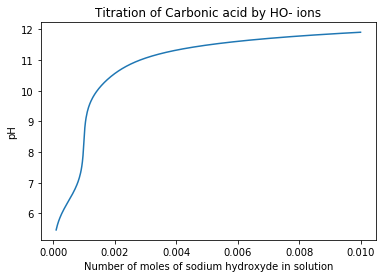

In [10]:
na_moles = np.linspace(1e-4, 10.e-3, 500)
sol_volume = 1. # Liter
carbo= Acid(pKa=[6.4,10.3], charge=0, conc=1.e-3) # pKa given at 25°C
phs = []
for mol in na_moles:
     na = Neutral(charge=1, conc=mol/sol_volume)
     system = System(carbo, na)
     system.pHsolve(guess_est=True)
     phs.append(system.pH)
plt.plot(na_moles, phs)

plt.title('Titration of Carbonic acid by HO- ions')
plt.xlabel('Number of moles of sodium hydroxyde in solution')
plt.ylabel('pH')
plt.savefig("titration.png")
plt.show()